# Download dataset form Kaggle - Flickr8k - Run once

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

In [ ]:
! mkdir train
! unzip flickr8k.zip -d train

In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
! mkdir glove
! unzip glove.6B.zip -d glove

# Load data

In [ ]:
import pandas as pd
import numpy as np
from time import time
from pickle import dump, load
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train/captions.txt')
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
# Split dataset of captions into training and validation sets with ratio 8:2
train, val = np.split(df.sample(frac = 1, random_state = 42), [int(.8 * len(df)), ])
print('Number of captions: ', len(df))
print('Training set shape: ', train.shape)
print('Validation set shape: ', val.shape)

Number of captions:  40455
Training set shape:  (32364, 2)
Validation set shape:  (8091, 2)


## Show an example

In [ ]:
imageFolderPath = 'train/Images/'

Size: (500, 375)
A brown dog on a leash runs through the white water .
A soaked dog is playing in the water .
A tan dog on a leash running in shallow ocean water .
A wet dog on a leash is running through some water .
Brown dog running through shallow water .


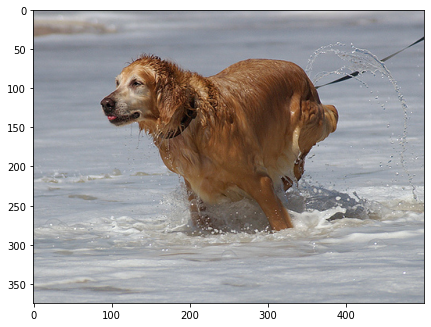

In [ ]:
n = 321
img = Image.open(imageFolderPath + df['image'][5 * n])
print("Size:", img.size)
plt.figure(figsize = (7, 7))
plt.imshow(img)
for i in range(5 * n, 5 * n + 5):
    print(df['caption'][i])

# Caption preprocessing

In [ ]:
import re
# Caption preprocessing - remove characters
def caption_preprocessing(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, ' ', text)
    text = text.split()
    text = [word.lower() for word in text]
    text = [word for word in text if word.isalpha()]
    text = ' '.join(text)
    text = 'startseq ' + text + ' endseq'
    return text

print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

startseq chao ban it s a table endseq


In [ ]:
df['caption'] = df['caption'].apply(caption_preprocessing)
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

## Count the number of words in dataset and max_length of a caption

In [ ]:
word_count = {}
max_length = 0
for text in df['caption']:
    words = text.split()
    max_length = len(words) if (max_length < len(words)) else max_length
    for w in words:
        try:
            word_count[w] += 1
        except:
            word_count[w] = 1

print("Number of words: ", len(word_count))
print("Maximum possible length of a caption: ", max_length)

Number of words:  8440
Maximum possible length of a caption:  38


In [ ]:
# create dictionary
word_count_threshold = 10 # hypeparameter
vocab = [word for word in word_count if word_count[word] >= word_count_threshold]
print('Preprocessed words %d -> %d' % (len(word_count), len(vocab)))

Preprocessed words 8440 -> 1963


In [ ]:
i2w = {}
w2i = {}

id = 1
for word in vocab:
    w2i[word] = id
    i2w[id] = word
    id += 1

print(len(i2w), len(w2i))

1963 1963


## Embedding word with Glove

In [ ]:
glove_dir = 'glove/'
embeddings_index = {}
file = open(glove_dir + 'glove.6B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['girl'].shape

In [ ]:
embedding_dim = 200
vocab_size = len(vocab) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(1964, 200)


In [ ]:
with open("/checkpoints/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("/checkpoints/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(1964, 200)

# Transfer learning on images, using Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()

96112376/96112376 [==============================] - 0s 0us/step


In [ ]:
from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Model
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
plot_model(model_new, show_shapes = True, show_layer_names = True)

In [ ]:
model_new.output_shape

(None, 2048)

In [ ]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
    images[df['image'][i]] = np.array(Image.open(imageFolderPath + df['image'][i]))
    try:
        captions[df['image'][i]].append(df['caption'][i])
    except:
        captions[df['image'][i]] = [df['caption'][i]]

print(len(images), len(captions))
print('Time: ', time() - start)

In [ ]:
with open("/checkpoints/encoded_captions.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/checkpoints/encoded_captions.pkl", "rb"))
len(captions)

8091

In [ ]:
images[df['image'][0]].shape

(500, 375, 3)

In [ ]:
from keras.applications.inception_v3 import preprocess_input
def embedding_image(image):
    # Resize to 299 x 299 as expected by the Inception model
    img = np.resize(image, (299, 299, 3))
    # Add one more dimesion
    img = np.expand_dims(img, axis = 0)
    # Preprocess the image
    img = preprocess_input(img)

    feature_vec = model_new.predict(img) # Get the embedding vector from image
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1]) # Reshape from (1, 2048) to (2048, )
    return feature_vec

In [ ]:
start = time()
encoding_images = {}
for id, img in images.items():
    encoding_images[id] = embedding_image(img)
print("Time taken for embedding images: ", time() - start)

In [ ]:
encoding_images[df['image'][0]].shape

(2048,)

In [ ]:
with open("/checkpoints/encoded_train_images.pkl", "wb") as file:
    dump(encoding_images, file)

In [ ]:
encoding_images = load(open("/checkpoints/encoded_train_images.pkl", "rb"))
len(encoding_images)

8091

# Training

In [ ]:
# Embedding word vector: embedding_matrix with shape (1964, 200)
# Embedding image vector: encoding_images - dictionary with len 8091
# Captions dictionary: captions
# Original images dictionary: images

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions, images, w2i, max_length, batch_size):
    X_image, X_cap, y = [], [], []
    n = 0
    while True:
        for id, caps in captions.items():
            n += 1
            image = images[id]
            for cap in caps:
                seq = [w2i[word] for word in cap.split(' ') if word in w2i]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                    X_image.append(image)
                    X_cap.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X_image), np.array(X_cap)], np.array(y))
                X_image, X_cap, y = [], [], []
                n = 0

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                                    Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
# Create model
inputs1 = Input(shape = (2048, ))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

inputs2 = Input(shape = (max_length))
se1 = Embedding(vocab_size, embedding_dim, mask_zero = True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

main_model = Model(inputs = [inputs1, inputs2], outputs = outputs)

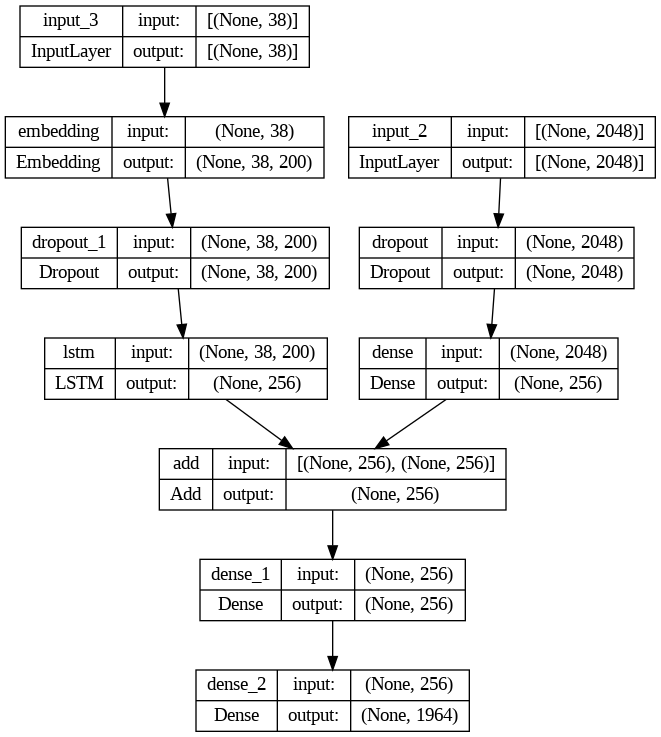

In [ ]:
plot_model(main_model, show_shapes=True, show_layer_names=True)

In [ ]:
main_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      392800      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
print(main_model.layers[2])
main_model.layers[2].set_weights([embedding_matrix])
main_model.layers[2].trainable = False

In [ ]:
main_model.compile(loss='categorical_crossentropy', optimizer = 'adam')

In [ ]:
main_model.optimizer.lr = 0.0001
epochs = 5
batch_size = 16
steps = len(encoding_images)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/image_captioning/cp.ckpt"

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
generator = data_generator(captions=captions, images=encoding_images, w2i=w2i, max_length=max_length, batch_size=batch_size)
main_model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

Epoch 1/5
8091/8091 [==============================] - ETA: 0s - loss: 3.6325
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/image_captioning/cp.ckpt
8091/8091 [==============================] - 1260s 155ms/step - loss: 3.6325
Epoch 2/5
8091/8091 [==============================] - ETA: 0s - loss: 3.0644
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/image_captioning/cp.ckpt
8091/8091 [==============================] - 1235s 153ms/step - loss: 3.0644
Epoch 3/5
8091/8091 [==============================] - ETA: 0s - loss: 2.8876
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/image_captioning/cp.ckpt
8091/8091 [==============================] - 1238s 153ms/step - loss: 2.8876
Epoch 4/5
8091/8091 [==============================] - ETA: 0s - loss: 2.7710
Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/image_captioning/cp.ckpt
8091/8091 [==============================] - 1227s 152ms/step - loss: 2.7710
Epoch 5/5
8091/8091 [===

In [ ]:
main_model.save('/checkpoints/model.h5')

# Demo

In [ ]:
import pandas as pd
import numpy as np
from time import time
from pickle import dump, load
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('/train/captions.txt')
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
imageFolderPath = '/train/Images/'

In [ ]:
import re
# Caption preprocessing - remove characters
def caption_preprocessing(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, ' ', text)
    text = text.split()
    text = [word.lower() for word in text]
    text = [word for word in text if word.isalpha()]
    text = ' '.join(text)
    text = 'startseq ' + text + ' endseq'
    return text

print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

startseq chao ban it s a table endseq


In [ ]:
df['caption'] = df['caption'].apply(caption_preprocessing)
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

In [ ]:
captions = load(open("/checkpoints/encoded_captions.pkl", "rb"))
len(captions)

8091

In [ ]:
encoding_images = load(open("/checkpoints/encoded_train_images.pkl", "rb"))
len(encoding_images)

8091

In [ ]:
word_count = {}
max_length = 0
for text in df['caption']:
    words = text.split()
    max_length = len(words) if (max_length < len(words)) else max_length
    for w in words:
        try:
            word_count[w] += 1
        except:
            word_count[w] = 1

print("Number of words: ", len(word_count))
print("Maximum possible length of a caption: ", max_length)

Number of words:  8440
Maximum possible length of a caption:  38


In [ ]:
# create dictionary
word_count_threshold = 10 # hypeparameter
vocab = [word for word in word_count if word_count[word] >= word_count_threshold]
print('Preprocessed words %d -> %d' % (len(word_count), len(vocab)))

Preprocessed words 8440 -> 1963


In [ ]:
i2w = {}
w2i = {}

id = 1
for word in vocab:
    w2i[word] = id
    i2w[id] = word
    id += 1

print(len(i2w), len(w2i))

1963 1963


# Load model and inference

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model('/checkpoints/model.h5')

In [ ]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      392800      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

startseq a couple guys splash through water wearing hard hats endseq
startseq two men are holding onto a rope climbing up forceful water endseq
startseq two men grapple up a waterfall endseq
startseq two people are getting soaked by a waterfall endseq
startseq water from the left splashing over a man with a white helmet endseq


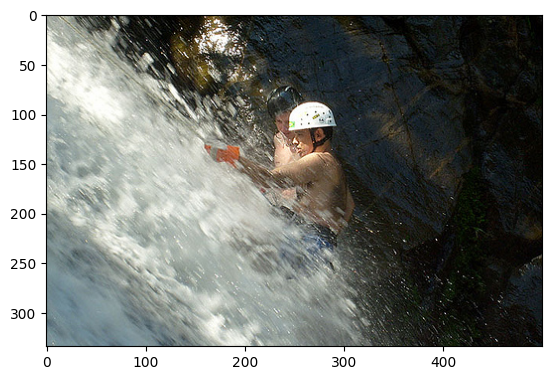

Predict: a man in a white shirt is standing in front of a building


In [ ]:
idx = 1613
pic = df['image'][idx * 5]
image = encoding_images[pic].reshape((1,2048))
img = Image.open(imageFolderPath + pic)
for i in range(idx * 5, idx * 5 + 5):
    print(df['caption'][i])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print("Predict:", predict)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def BLEU_SCORE(idx):
    reference = [cap.split()[1:-1] for cap in df['caption'][5 * idx : 5 * idx + 5]]
    pic = df['image'][5 * idx]
    image = encoding_images[pic].reshape((1,2048))
    predict = greedySearch(image)
    candidate = predict.split()
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    return score

In [ ]:
scores = BLEU_SCORE(idx)